In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn import linear_model, decomposition, datasets
from sklearn.model_selection import train_test_split

from utils import *

### Load and explore data

In [2]:
data = pd.read_csv('creditcard.csv')
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
fradulent = data[data['Class'] == 1]
legit = data[data['Class'] == 0]

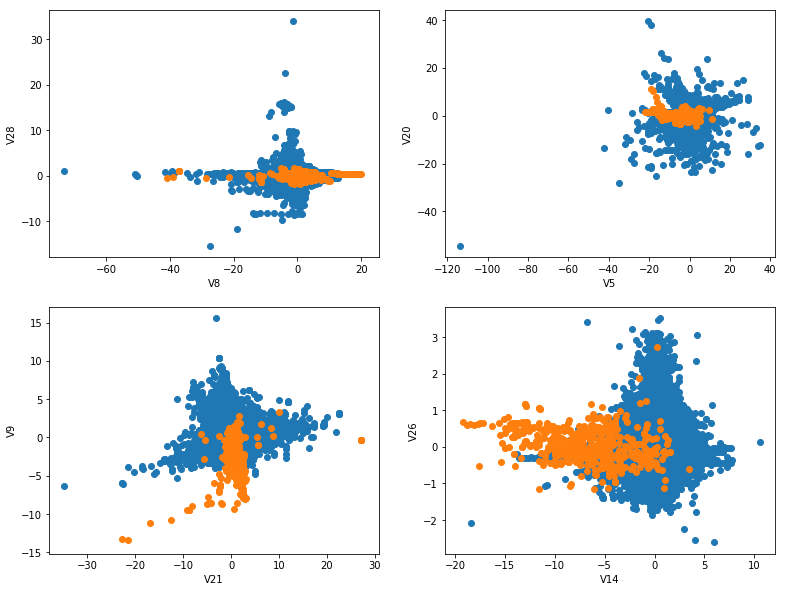

In [6]:
col_names = list(data.columns)[1:-1] ## TODO what is this?
tile_random_features(col_names, data)

### Prep data

In [7]:
train, test = train_test_split(data, test_size=0.2)

print '% of fraud cases in original, train, and test sets:'
print len(fradulent)*1.0/len(data)
print len(train[train['Class']==1])*1.0/len(train)
print len(test[test['Class']==1])*1.0/len(test)

% of fraud cases in original, train, and test sets:
0.00172748563062
0.00173363470781
0.00170288964573


In [8]:
# Split into features / class labels
train_x, train_y = [df.as_matrix() for df in split_by_class(train)]
test_x, test_y = [df.as_matrix() for df in split_by_class(test)]

## Performance Metrics

Note that a dumb majority class classifier has incredible accuracy!

In [9]:
from sklearn.metrics import accuracy_score
bs_pred = np.zeros(test_y.shape)
accuracy_score(test_y, bs_pred)

0.99829711035427127

That's hard to beat!

However what we really care about is not primarily accurancy. We want high recall so that we can find as much fraud ass possible while not creating _too_ many false positives

In [10]:
from sklearn.metrics import recall_score
print "Recall:"
recall_score(test_y, bs_pred)

Recall:


0.0

Recall is quite bad, making this a very poor classifier for finding fraud

Thus we will try to find a sampling methods that has good recall and better-than-horrible precision (or alternatively, high accurancy).

## Implement sampling methods on training data

According to we background we did to test different classifiers we are going to test our sampling methods on 3 classifiers: Logistic Regression, QDA, and Decision Trees (CART)

In [29]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

In [28]:
# best results from hyper parameter search
logit_params = {'penalty': 'l2', 'C': 0.01}

### Over sampling

In [30]:
from imblearn.over_sampling import RandomOverSampler
train_x_res, train_y_res = RandomOverSampler().fit_sample(train_x, train_y)
print_class_counts(train_y_res)

Class counts:
[(0, 227450), (1, 227450)]


In [31]:
run_compare_sampling(RandomOverSampler, LogisticRegression, train_x_res, train_y_res, test_x, test_y, **logit_params)
run_compare_sampling(RandomOverSampler, QuadraticDiscriminantAnalysis, train_x, train_y, test_x, test_y)
run_compare_sampling(RandomOverSampler, DecisionTreeClassifier, train_x, train_y, test_x, test_y)

Sampler: RandomOverSampler
Class counts:
[(0, 227450), (1, 227450)]

LogisticRegression
Recall: 	0.886597938144
Precision:	0.0697485806975
F1 Score:	0.129323308271
Accuracy:	0.979670657631
Confusion mat: 
[[55718  1147]
 [   11    86]]

LogisticRegression
Recall: 	0.886597938144
Precision:	0.0697485806975
F1 Score:	0.129323308271
Accuracy:	0.979670657631
Confusion mat: 
[[55718  1147]
 [   11    86]]

Sampler: RandomOverSampler
Class counts:
[(0, 227450), (1, 227450)]

QuadraticDiscriminantAnalysis
Recall: 	0.865979381443
Precision:	0.0569491525424
F1 Score:	0.106870229008
Accuracy:	0.975351989045
Confusion mat: 
[[55474  1391]
 [   13    84]]

QuadraticDiscriminantAnalysis
Recall: 	0.886597938144
Precision:	0.0430215107554
F1 Score:	0.0820610687023
Accuracy:	0.966223096099
Confusion mat: 
[[54952  1913]
 [   11    86]]

Sampler: RandomOverSampler
Class counts:
[(0, 227450), (1, 227450)]

DecisionTreeClassifier
Recall: 	0.752577319588
Precision:	0.73
F1 Score:	0.741116751269
Accuracy:	

### Under sampling

In [32]:
from imblearn.under_sampling import RandomUnderSampler
train_x_res, train_y_res = RandomUnderSampler().fit_sample(train_x, train_y)
print_class_counts(train_y_res)

Class counts:
[(0, 395), (1, 395)]


In [33]:
run_compare_sampling(RandomUnderSampler, LogisticRegression, train_x_res, train_y_res, test_x, test_y,**logit_params)
run_compare_sampling(RandomUnderSampler, QuadraticDiscriminantAnalysis, train_x, train_y, test_x, test_y)
run_compare_sampling(RandomUnderSampler, DecisionTreeClassifier, train_x, train_y, test_x, test_y)

Sampler: RandomUnderSampler
Class counts:
[(0, 395), (1, 395)]

LogisticRegression
Recall: 	0.896907216495
Precision:	0.0744863013699
F1 Score:	0.137549407115
Accuracy:	0.980846880376
Confusion mat: 
[[55784  1081]
 [   10    87]]

LogisticRegression
Recall: 	0.896907216495
Precision:	0.074358974359
F1 Score:	0.137332280979
Accuracy:	0.98081176925
Confusion mat: 
[[55782  1083]
 [   10    87]]

Sampler: RandomUnderSampler
Class counts:
[(0, 395), (1, 395)]

QuadraticDiscriminantAnalysis
Recall: 	0.865979381443
Precision:	0.0569491525424
F1 Score:	0.106870229008
Accuracy:	0.975351989045
Confusion mat: 
[[55474  1391]
 [   13    84]]

QuadraticDiscriminantAnalysis
Recall: 	0.896907216495
Precision:	0.0251445086705
F1 Score:	0.0489176272139
Accuracy:	0.94060952916
Confusion mat: 
[[53492  3373]
 [   10    87]]

Sampler: RandomUnderSampler
Class counts:
[(0, 395), (1, 395)]

DecisionTreeClassifier
Recall: 	0.742268041237
Precision:	0.765957446809
F1 Score:	0.753926701571
Accuracy:	0.999174

### SMOTE/ADASYN oversampling

In [24]:
from imblearn.over_sampling import SMOTE, ADASYN
train_x_res, train_y_res = SMOTE(kind='regular').fit_sample(train_x, train_y)
print_class_counts(train_y_res)

Class counts:
[(0, 227450), (1, 227450)]


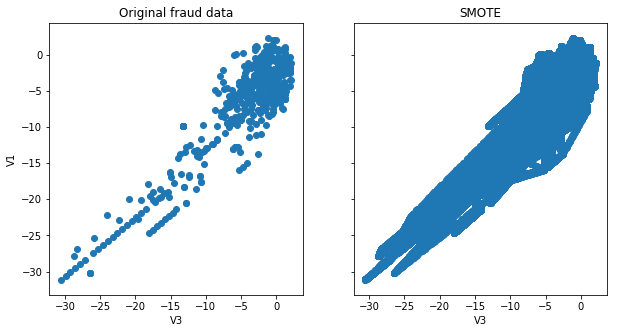

In [25]:
minorty = train_x_res[train_y_res == 1]
col_names = fradulent.columns
cols = (1,3)

fig, axarr = plt.subplots(1,2,sharey=True,figsize=(10,5))
ax_orig = axarr[0]
ax_smote = axarr[1]

ax_orig.scatter(fradulent[col_names[cols[0]]],fradulent[col_names[cols[1]]])
ax_orig.set_title('Original fraud data')
ax_orig.set_ylabel(col_names[cols[0]])
ax_orig.set_xlabel(col_names[cols[1]])

ax_smote.scatter(minorty[:,cols[0]], minorty[:,cols[1]])
ax_smote.set_title('SMOTE')
ax_smote.set_xlabel(col_names[cols[1]])

plt.show()

In [26]:
run_compare_sampling(SMOTE, LogisticRegression, train_x_res, train_y_res, test_x, test_y,**logit_params)
run_compare_sampling(SMOTE, QuadraticDiscriminantAnalysis, train_x, train_y, test_x, test_y)
run_compare_sampling(SMOTE, DecisionTreeClassifier, train_x, train_y, test_x, test_y)

Sampler: SMOTE
Class counts:
[(0, 227450), (1, 227450)]

LogisticRegression
Recall: 	0.886597938144
Precision:	0.103365384615
F1 Score:	0.185145317546
Accuracy:	0.986710438538
Confusion mat: 
[[56119   746]
 [   11    86]]

LogisticRegression
Recall: 	0.886597938144
Precision:	0.103365384615
F1 Score:	0.185145317546
Accuracy:	0.986710438538
Confusion mat: 
[[56119   746]
 [   11    86]]

Sampler: SMOTE
Class counts:
[(0, 227450), (1, 227450)]

QuadraticDiscriminantAnalysis
Recall: 	0.865979381443
Precision:	0.0569491525424
F1 Score:	0.106870229008
Accuracy:	0.975351989045
Confusion mat: 
[[55474  1391]
 [   13    84]]

QuadraticDiscriminantAnalysis
Recall: 	0.886597938144
Precision:	0.0562091503268
F1 Score:	0.105716041795
Accuracy:	0.974456655314
Confusion mat: 
[[55421  1444]
 [   11    86]]

Sampler: SMOTE
Class counts:
[(0, 227450), (1, 227450)]

DecisionTreeClassifier
Recall: 	0.752577319588
Precision:	0.760416666667
F1 Score:	0.756476683938
Accuracy:	0.999174888522
Confusion mat:

In [27]:
run_compare_sampling(ADASYN, LogisticRegression, train_x_res, train_y_res, test_x, test_y, **logit_params)
run_compare_sampling(ADASYN, QuadraticDiscriminantAnalysis, train_x, train_y, test_x, test_y)
run_compare_sampling(ADASYN, DecisionTreeClassifier, train_x, train_y, test_x, test_y)

Sampler: ADASYN
Class counts:
[(0, 227450), (1, 227450)]

LogisticRegression
Recall: 	0.886597938144
Precision:	0.103365384615
F1 Score:	0.185145317546
Accuracy:	0.986710438538
Confusion mat: 
[[56119   746]
 [   11    86]]

LogisticRegression
Recall: 	0.886597938144
Precision:	0.103365384615
F1 Score:	0.185145317546
Accuracy:	0.986710438538
Confusion mat: 
[[56119   746]
 [   11    86]]

Sampler: ADASYN
Class counts:
[(0, 227450), (1, 227397)]

QuadraticDiscriminantAnalysis
Recall: 	0.865979381443
Precision:	0.0569491525424
F1 Score:	0.106870229008
Accuracy:	0.975351989045
Confusion mat: 
[[55474  1391]
 [   13    84]]

QuadraticDiscriminantAnalysis
Recall: 	0.896907216495
Precision:	0.0415671285237
F1 Score:	0.0794520547945
Accuracy:	0.96460798427
Confusion mat: 
[[54859  2006]
 [   10    87]]

Sampler: ADASYN
Class counts:
[(0, 227450), (1, 227397)]

DecisionTreeClassifier
Recall: 	0.762886597938
Precision:	0.762886597938
F1 Score:	0.762886597938
Accuracy:	0.999192444086
Confusion m